In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
main = pd.read_csv('prior.csv')
main.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,2,8,NaN
1,2398795,1,2,3,7,15.0
2,473747,1,3,3,12,21.0
3,2254736,1,4,4,7,29.0
4,431534,1,5,4,15,28.0


# Brief EDA

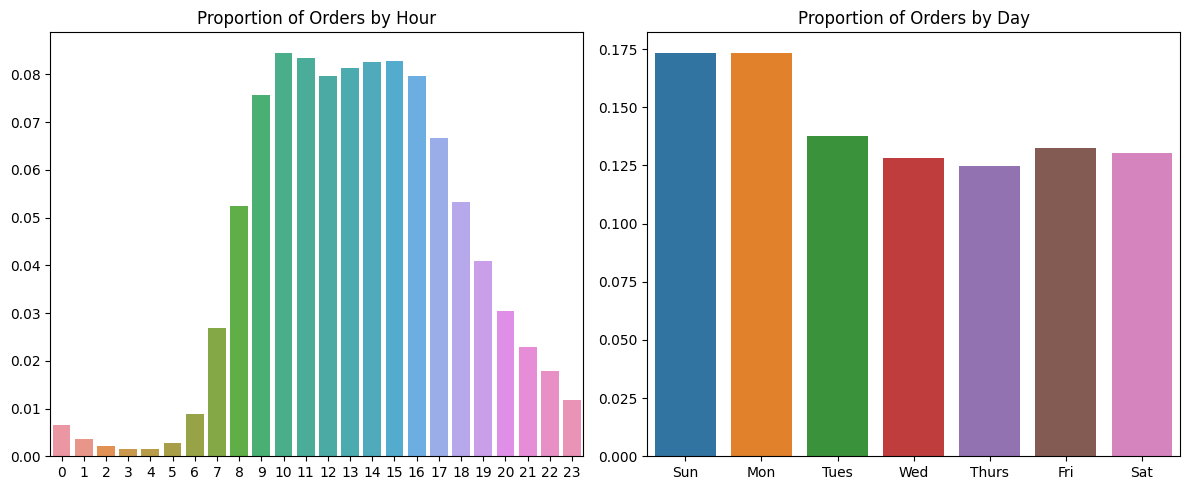

In [3]:
order_hour_plot = main.order_hour_of_day.value_counts(normalize=True).sort_index()
order_dow_plot = main.order_dow.value_counts(normalize=True).sort_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(x=order_hour_plot.index, y=order_hour_plot, ax=ax1);
ax1.set_title('Proportion of Orders by Hour')
ax1.set_ylabel('')
ax1.set_xlabel('')
sns.barplot(x=order_dow_plot.index, y=order_dow_plot, ax=ax2);
ax2.set_title('Proportion of Orders by Day')
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.set_xticks(np.arange(0, 7), ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'])
plt.tight_layout()

del order_hour_plot, order_dow_plot

In [4]:
prior_orders = pd.read_csv('order_products_prior.csv')
prior_orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [5]:
products = pd.read_csv('products.csv')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [6]:
# Merging DataFrames together
prior_orders = prior_orders.merge(products, on='product_id', how='left')
prior_orders = prior_orders.astype({'order_id': np.int32, 'product_id': np.int32, 'add_to_cart_order': np.int16, 'reordered': np.int16, 'aisle_id': np.int16, 'department_id': np.int16})

In [7]:
departments = pd.read_csv('departments.csv')
aisles = pd.read_csv('aisles.csv')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [8]:
# More merging
prior_orders['aisle'] = prior_orders['aisle_id'].map(aisles.set_index('aisle_id').aisle.to_dict())
prior_orders['department'] = prior_orders['department_id'].map(departments.set_index('department_id').department.to_dict())

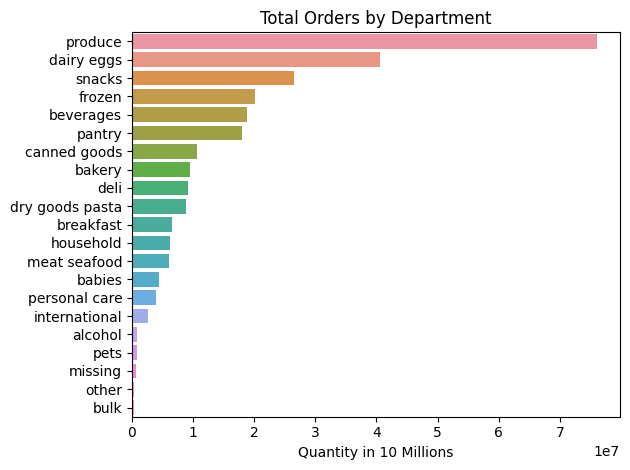

In [9]:
department_orders = prior_orders.groupby('department').add_to_cart_order.sum().sort_values(ascending=False)
sns.barplot(y=department_orders.index, x=department_orders, orient='h');
plt.title('Total Orders by Department')
plt.ylabel('')
plt.xlabel('Quantity in 10 Millions')
plt.tight_layout();

# Association Rules Mining

In [10]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

In [11]:
prior_orders.shape

(32434489, 9)

The next few steps involve reducing the size of the dataset.

In [12]:
# Selecting transactions that have more than 2 orders
orders_more_than_2_items = prior_orders.order_id.value_counts()[prior_orders.order_id.value_counts() != 1].index
orders_more_than_2_items = prior_orders.query('order_id in @orders_more_than_2_items')

In [13]:
# Selecting products that appear in more than 0.0001% of total transactions
products_more_than_point1 = orders_more_than_2_items.product_name.value_counts().sort_values()[orders_more_than_2_items.product_name.value_counts().sort_values() > 32434].index

In [14]:
reduced_prior_orders = prior_orders.query('product_name in @products_more_than_point1')
reduced_prior_orders.shape

(7516415, 9)

In [15]:
itemsets = reduced_prior_orders.groupby('order_id').product_name.unique()
len(itemsets)

2353246

In [16]:
te = TransactionEncoder()
te_ary = te.fit_transform(itemsets)
itemsets_df = pd.DataFrame(te_ary, columns=te.columns_)

In [17]:
frequent_itemsets = fpgrowth(itemsets_df, min_support=0.01, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.030909,(Carrots)
1,0.028662,(Michigan Organic Kale)
2,0.102803,(Organic Baby Spinach)
3,0.022134,(Organic Ginger Root)
4,0.021064,(Unsweetened Almondmilk)
...,...,...
126,0.017521,"(Banana, Strawberries)"
127,0.010095,"(Organic Blueberries, Organic Strawberries)"
128,0.013501,"(Banana, Limes)"
129,0.011645,"(Large Lemon, Limes)"


In [18]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2).sort_values('lift', ascending=False)
rules[rules.duplicated(['support', 'lift'])].iloc[:, :7]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
45,(Limes),(Large Lemon),0.059759,0.064871,0.011645,0.194863,3.003862
14,(Organic Raspberries),(Organic Strawberries),0.058242,0.112476,0.014390,0.247072,2.196673
42,(Organic Blueberries),(Organic Strawberries),0.042520,0.112476,0.010095,0.237418,2.110834
13,(Organic Raspberries),(Organic Hass Avocado),0.058242,0.090761,0.010961,0.188192,2.073477
39,(Organic Fuji Apple),(Banana),0.038089,0.200814,0.014424,0.378693,1.885788
11,(Organic Raspberries),(Bag of Organic Bananas),0.058242,0.161245,0.017212,0.295519,1.832731
5,(Bag of Organic Bananas),(Organic Hass Avocado),0.161245,0.090761,0.026491,0.164293,1.810164
27,(Honeycrisp Apple),(Banana),0.033897,0.200814,0.012072,0.356128,1.773423
6,(Organic Hass Avocado),(Organic Baby Spinach),0.090761,0.102803,0.014831,0.163406,1.589509
25,(Organic Strawberries),(Organic Whole Milk),0.112476,0.058602,0.010119,0.089968,1.535237


Whenever an order contains Limes, there is approximately a 19% probability of Large Lemon being in the same order too. The presence of either Limes or Large Lemon in an order increases the likelihood of the other by approximately 3 times.

# Customer Segmentation

In [19]:
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans, Birch
from scipy.cluster import hierarchy

I'll perform customer segmentation on two levels. The first level segments customers on their orders grouped by department. There'll be 4 departments:
1. Alcohol, babies, and pets because they are potentially distinct segments.
2. 'Generic' which is a basket group of the remaining departments.

The second level sub-segments each department segment based on their total number of orders and average reorders.
* 0: High number of orders, high number of reorders -> Repeat, habitual shoppers
* 1: High number of orders, low number of reorders -> Repeat, curious shoppers
* 2: Low number of orders, high number of reorders -> New, habitual shoppers
* 3: Low number of orders, low number of reorders -> New, at-risk shoppers

In [20]:
prior_orders.loc[~prior_orders['department_id'].isin([5, 8, 18]), 'department'] = 'others' # alcohol - 5, pets - 8, babies - 18
prior_orders['user_id'] = prior_orders.order_id.map(main.set_index('order_id').user_id.to_dict())

In [21]:
segment_df = prior_orders.groupby('user_id').department.value_counts().unstack().fillna(0)
segment_df['num_orders'] = segment_df.index.map(main.groupby('user_id').order_number.max().to_dict())
segment_df['avg_reorders'] = segment_df.index.map(round(prior_orders.groupby('user_id').reordered.sum() / main.groupby('user_id').order_number.max(), 2).to_dict())

In [22]:
segment_df.head()

department,alcohol,babies,others,pets,num_orders,avg_reorders
user_id,,,,,,
1,0.0,0.0,59.0,0.0,10,4.10
2,0.0,0.0,195.0,0.0,14,6.64
3,0.0,0.0,88.0,0.0,12,4.58
4,2.0,0.0,16.0,0.0,5,0.20
5,0.0,0.0,37.0,0.0,4,3.50


In [23]:
kmeans = KMeans(4, n_init='auto', random_state=42)
kmeans.fit(scale(segment_df.iloc[:, :4]))
segment_df.groupby(kmeans.labels_).mean()

department,alcohol,babies,others,pets,num_orders,avg_reorders
0,0.459965,0.977758,144.896390,0.338223,14.937359,4.310494
1,3.395833,3.154762,466.005952,77.235119,40.080357,10.097976
2,0.189804,71.883296,675.615903,0.570055,48.199102,11.827878
3,70.096085,1.326216,283.829181,2.021352,41.586002,5.389917


In [24]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3]), array([201911,    336,   3119,    843], dtype=int64))

The model segments the data neatly, with the average number of items ordered in each department of interest being distinctly higher in each segment and the distribution of the segments aligns nicely with the total orders per department. In addition, the model also reveals that the generic shopper segment has on average fewer orders and reorders, suggesting that shoppers in this segment are not so loyal customers.
* Segment 0: Generic shopper
* Segment 1: Pet shopper
* Segment 2: Baby shopper
* Segment 3: Alcohol shopper


In [25]:
segment_df['shopper_department'] = kmeans.labels_

In [26]:
pet_shopper = segment_df.query('shopper_department == 1').iloc[:, [4, 5]]
baby_shopper = segment_df.query('shopper_department == 2').iloc[:, [4, 5]]
alcohol_shopper = segment_df.query('shopper_department == 3').iloc[:, [4, 5]]
generic_shopper = segment_df.query('shopper_department == 0').iloc[:, [4, 5]]

In [27]:
alcohol_linkages = hierarchy.linkage(scale(alcohol_shopper), method='centroid')
alcohol_labels = hierarchy.fcluster(alcohol_linkages, t=4, criterion='maxclust')
alcohol_shopper.groupby(alcohol_labels).mean()

department,num_orders,avg_reorders
1,93.144444,5.868111
2,35.358871,5.090336
3,89.000000,24.755000
4,27.000000,25.550000


In [28]:
alcohol_shopper['group'] = pd.Series(alcohol_labels).map({1: 1, 2: 3, 3: 0, 4: 2}).tolist()

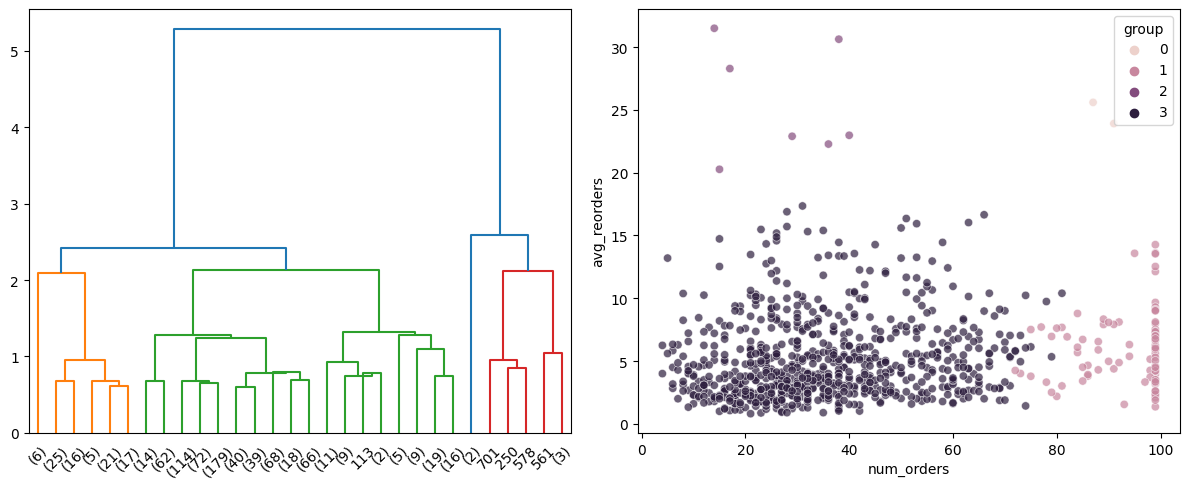

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
hierarchy.dendrogram(alcohol_linkages, truncate_mode='lastp', color_threshold=2.2, ax=ax1)
sns.scatterplot(x=alcohol_shopper.num_orders, y=alcohol_shopper.avg_reorders, hue=alcohol_shopper.group, alpha=0.7, ax=ax2)
plt.tight_layout()

In [30]:
pet_linkages = hierarchy.linkage(scale(pet_shopper), method='median')
pet_labels = hierarchy.fcluster(pet_linkages, t=4, criterion='maxclust')
pet_shopper.groupby(pet_labels).mean()

department,num_orders,avg_reorders
1,28.790323,18.900323
2,32.948837,7.607953
3,85.533333,4.490667
4,75.340909,11.773409


In [31]:
pet_shopper['group'] = pd.Series(pet_labels).map({1: 2, 2: 3, 3: 1, 4: 0}).tolist()

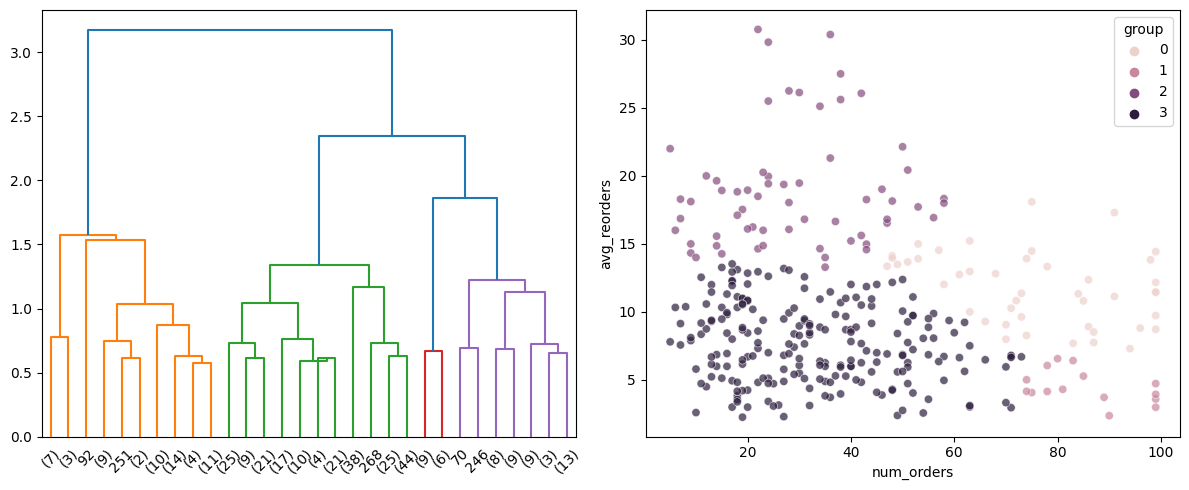

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
hierarchy.dendrogram(pet_linkages, truncate_mode='lastp', color_threshold=1.6, ax=ax1)
sns.scatterplot(x=pet_shopper.num_orders, y=pet_shopper.avg_reorders, hue=pet_shopper.group, alpha=0.7, ax=ax2)
plt.tight_layout()

In [33]:
baby_linkages = hierarchy.linkage(baby_shopper, method='median')
baby_labels = hierarchy.fcluster(baby_linkages, t=4, criterion='maxclust')
baby_shopper.groupby(baby_labels).mean()

department,num_orders,avg_reorders
1,26.255814,27.637674
2,30.452381,10.809571
3,49.023196,18.874278
4,78.395833,10.138323


In [34]:
baby_shopper['group'] = pd.Series(baby_labels).map({1: 2, 2:3, 3: 0, 4: 1}).tolist()

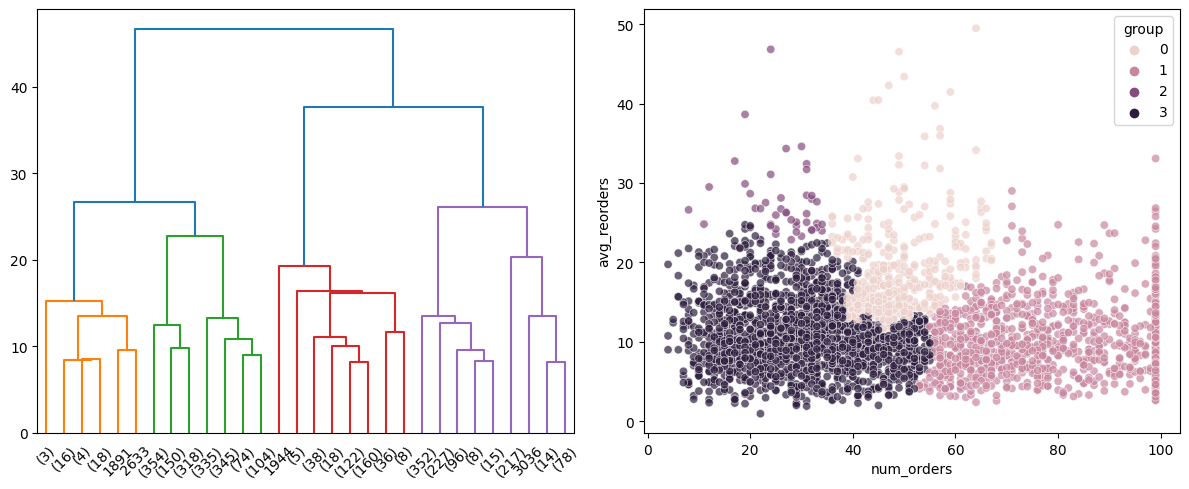

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
hierarchy.dendrogram(baby_linkages, truncate_mode='lastp', color_threshold=26.5, ax=ax1)
sns.scatterplot(x=baby_shopper.num_orders, y=baby_shopper.avg_reorders, hue=baby_shopper.group, alpha=0.7, ax=ax2)
plt.tight_layout()

In [36]:
brc = Birch(n_clusters=4, threshold=0.02, branching_factor=50)
brc.fit(scale(generic_shopper))
generic_shopper.groupby(brc.labels_).mean()

department,num_orders,avg_reorders
0,12.301498,3.841266
1,60.194073,12.490988
2,18.419362,17.179784
3,71.099586,5.231328


In [37]:
generic_shopper['group'] = pd.Series(brc.labels_).map({0: 3, 1:0, 2: 1, 3: 2}).tolist()

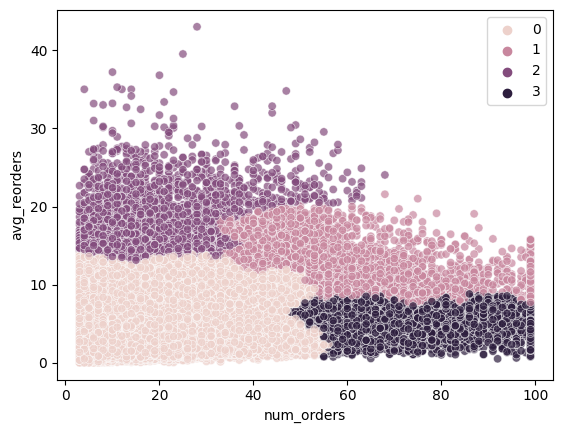

In [38]:
# branching factor 50, threshold 0.02
sns.scatterplot(x=generic_shopper.num_orders, y=generic_shopper.avg_reorders, hue=brc.labels_, alpha=0.7);

In [39]:
segment_df['shopper_type'] = pd.concat((alcohol_shopper.group, pet_shopper.group, baby_shopper.group, generic_shopper.group)).sort_index()

In [40]:
segment_df.sample(frac=.1, random_state=611666)

department,alcohol,babies,others,pets,num_orders,avg_reorders,shopper_department,shopper_type
user_id,,,,,,,,
197333,0.0,0.0,36.0,0.0,9,1.33,0,3
142589,0.0,0.0,58.0,0.0,5,3.60,0,3
15857,0.0,54.0,575.0,0.0,46,11.41,2,0
106170,0.0,0.0,17.0,0.0,3,1.00,0,3
20793,0.0,0.0,92.0,0.0,7,3.00,0,3
...,...,...,...,...,...,...,...,...
135369,0.0,0.0,80.0,0.0,6,4.33,0,3
140219,0.0,0.0,9.0,0.0,6,0.67,0,3
87182,13.0,0.0,134.0,0.0,43,2.00,0,3


* user_id 197333 is a new, at-risk generic shopper. 
* user_id 15857 is a repeat, habitual baby shopper. 